# Spatial Feature Engineering (I)

## Map Matching

## 📖 Ahead of time...

Feature Engineering is a common term in machine learning that refers to the processes and transformations involved in turning data from the state in which the modeller access them into what is then fed to a model. This can take several forms, from standardisation of the input data, to the derivation of numeric scores that better describe aspects (*features*) of the data we are using. 

*Spatial* Feature Engineering refers to operations we can use to derive "views" or summaries of our data that we can use in models, *using space* as the key medium to create them.

There is only one reading to complete for this block, [Chapter 12](https://geographicdata.science/book/notebooks/12_feature_engineering.html) of the GDS Book {cite}`reyABwolf`. The first block of Spatial Feature Engineering in this course loosely follows the first part of the chapter ([Map Matching](https://geographicdata.science/book/notebooks/12_feature_engineering.html#feature-engineering-using-map-matching)), so focus on this first sections for the block.

## 💻 Hands-on coding

In [1]:
import pandas
import geopandas
import xarray, rioxarray
import contextily
import numpy as np
import matplotlib.pyplot as plt

```{margin} Data
If you want to read more about the data sources behind this dataset, head to the [Datasets](../data/datasets) section
```



````{tabbed} Local files

Assuming you have the file locally on the path `../data/`: 

```python
regions = geopandas.read_file("../data/cambodia_regional.gpkg")
cities = geopandas.read_file("../data/cambodian_cities.geojson")
pollution = rioxarray.open_rasterio(
    "../data/cambodia_s5_no2.tif"
).sel(band=1)
friction = rioxarray.open_rasterio(
    "../data/cambodia_2020_motorized_friction_surface.tif"
).sel(band=1)
```
````

````{tabbed} Online read

If you're online, you can do:

```python
regions = geopandas.read_file(
    "https://darribas.org/gds4ae/_downloads/9366d230310a8a68b2ce6cf2787a2f1c/cambodia_regional.gpkg"
)
cities = geopandas.read_file(
    "https://darribas.org/gds4ae/_downloads/b2bc4ad46ffb5fcec467286c022adf14/cambodian_cities.geojson"
)
pollution = rioxarray.open_rasterio(
    "https://darribas.org/gds4ae/_downloads/0d14506cd792aecf73dd0f7f027e95b4/cambodia_s5_no2.tif"
).sel(band=1)
friction = rioxarray.open_rasterio(
    "https://darribas.org/gds4ae/_downloads/f41b238a4d072a8a3eb5ce1794cd126a/cambodia_2020_motorized_friction_surface.tif"
).sel(band=1)
```
````


In [2]:
regions = geopandas.read_file("../data/cambodia_regional.gpkg")
cities = geopandas.read_file("../data/cambodian_cities.geojson")
pollution = rioxarray.open_rasterio(
    "../data/cambodia_s5_no2.tif"
).sel(band=1)
friction = rioxarray.open_rasterio(
    "../data/cambodia_2020_motorized_friction_surface.tif"
).sel(band=1)

Check both geo-tables and the surface are in the same CRS:

In [3]:
(
    regions.crs.to_epsg() ==
    cities.crs.to_epsg() ==
    pollution.rio.crs.to_epsg()
)

True

### Polygons to points

*In which region is a city?*

In [4]:
sj = geopandas.sjoin(cities, regions)

In [5]:
#   City name | Region name
sj[["UC_NM_MN", "adm2_name"]]

,UC_NM_MN,adm2_name
0,Sampov Lun,Sampov Lun
1,Khum Pech Chenda,Phnum Proek
2,Poipet,Paoy Paet
3,Sisophon,Serei Saophoan
4,Battambang,Battambang
5,Siem Reap,Siem Reap
6,Sihanoukville,Preah Sihanouk
7,N/A,Trapeang Prasat
8,Kampong Chhnang,Kampong Chhnang
9,Phnom Penh,Tuol Kouk


```{admonition} Challenge
Using the Madrid AirBnb [properties](data_abb) and [neighbourhoods](data_abb_neis) dataset, can you determine the neighbourhood group of the first ten properties?
```

### Points to polygons

If we were after the number of cities per region, it is a similar approach, with a (`groupby`) twist at the end:

````{margin}
```{note}

1. We `set_index` to align both tables
1. We `assign` to create a new column

If you want no missing values, you can `fillna(0)` since you *know* missing data are zeros
```
````

In [6]:
regions.set_index(
    "adm2_name"
).assign(
    city_count=sj.groupby("adm2_name").size()
).info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 198 entries, Mongkol Borei to Administrative unit not available
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   adm2_altnm  122 non-null    object  
 1   motor_mean  198 non-null    float64 
 2   walk_mean   198 non-null    float64 
 3   no2_mean    198 non-null    float64 
 4   geometry    198 non-null    geometry
 5   city_count  11 non-null     float64 
dtypes: float64(4), geometry(1), object(1)
memory usage: 10.8+ KB


```{admonition} Challenge
Using the Madrid AirBnb [properties](data_abb), can you compute how many properties each neighbourhood group has?
```

### Surface to points

Consider attaching to each city in `cities` the pollution level, as expressed in `pollution`.

```{margin}
The code for generating this figure is a bit more advanced as it fiddles with text, but if you want to explore it you can toggle it on
```

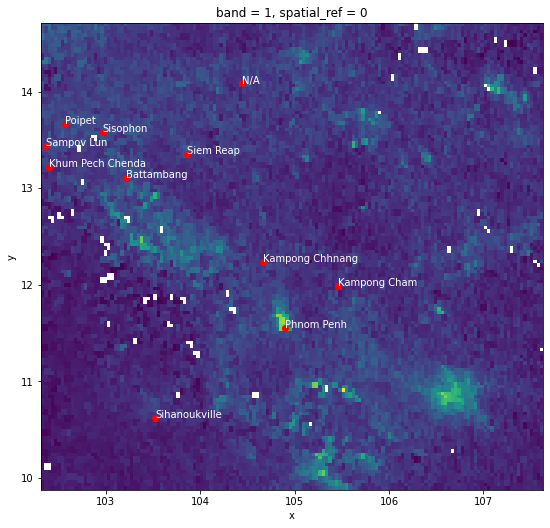

In [7]:
f, ax = plt.subplots(1, figsize=(9, 9))

pollution.where(
    pollution>0
).plot(
    ax=ax, add_colorbar=False
)

for i, row in cities.iterrows():
    plt.text(
        row.geometry.x,
        row.geometry.y,
        row["UC_NM_MN"],
        fontdict={"color": "white"},
    )
    
cities.plot(ax=ax, color="r");

In [8]:
from rasterstats import point_query

city_pollution = point_query(
    cities,
    pollution.values,
    affine=pollution.rio.transform(),
    nodata=pollution.rio.nodata
)
city_pollution

[3.9397064813333136e-05,
 3.4949825609644426e-05,
 3.825255125820345e-05,
 4.103826573585785e-05,
 3.067677208474005e-05,
 5.108273256655399e-05,
 2.2592785882580366e-05,
 4.050414400882722e-05,
 2.4383652926989897e-05,
 0.0001285838935209779,
 3.258245740282522e-05]

And we can map these on the city locations:

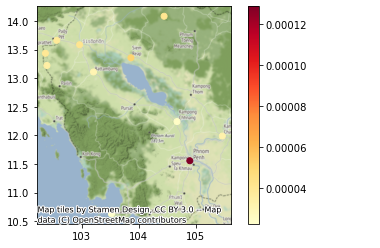

In [9]:
ax = cities.assign(
    pollution=city_pollution
).plot(
    "pollution", 
    cmap="YlOrRd",
    legend=True
)

contextily.add_basemap(
    ax=ax, crs=cities.crs,
);

```{admonition} Challenge
Can you calculate the pollution level at the centroid of each Cambodian region in the [regional aggregates](data_cam_friction_reg) dataset? how does it compare to their average value?
```

### Surface to polygons

Instead of transferring to points, we want to aggregate all the information in a surface that falls *within* a polygon. 

For this case, we will use the motorised friction surface. The question we are asking thus is: *what is the average degree of friction of each region?* Or, in other words: *what regions are harder to get through with motorised transport?*

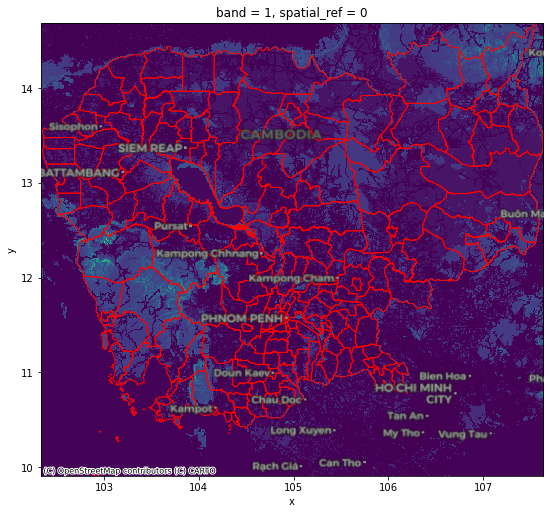

In [10]:
f, ax = plt.subplots(1, figsize=(9, 9))
friction.plot.imshow(
    add_colorbar=False, ax=ax
)
regions.plot(
    ax=ax, edgecolor="red", facecolor="none"
)
contextily.add_basemap(
    ax, 
    crs=regions.crs,
    source=contextily.providers.CartoDB.DarkMatterOnlyLabels,
    zoom=7
)

Again, we can rely on `rasterstats`:

```{margin}
The output is returned from `zonal_stats` as a list of dicts. To make it more manageable, we convert it into a `pandas.DataFrame`.
```

In [11]:
from rasterstats import zonal_stats

regional_friction = pandas.DataFrame(
    zonal_stats(
        regions,
        friction.values,
        affine=friction.rio.transform(),
        nodata=friction.rio.nodata
    ),
    index=regions.index
)
regional_friction.head()

,min,max,mean,count
0,0.001200,0.037000,0.006494,979
1,0.001200,0.060000,0.007094,1317
2,0.001200,0.024112,0.006878,324
3,0.001333,0.060000,0.009543,758
4,0.001200,0.060132,0.008619,55


This can then also be mapped onto the polygon geography:

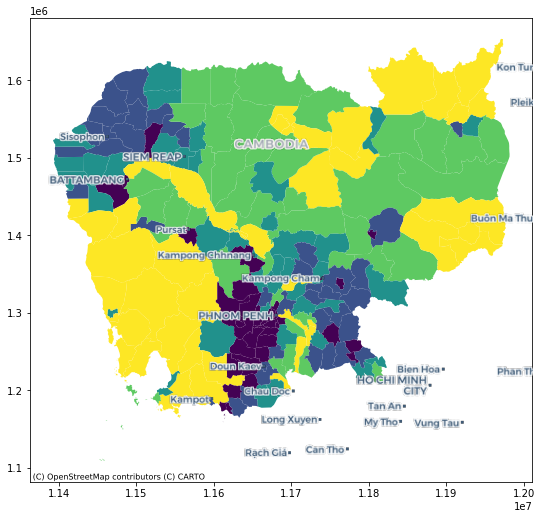

In [12]:
f, ax = plt.subplots(1, figsize=(9, 9))
regions.to_crs(
    epsg=3857
).join(
    regional_friction
).plot(
    "mean", scheme="quantiles", ax=ax
)
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.VoyagerOnlyLabels,
    zoom=7
)

```{admonition} Challenge
Replicate the analysis above to obtain the average friction for each region using the walking surface (`cambodia_2020_walking_friction_surface.tif`).
```

(sfe_s2s)=


### Surface to surface

If we want to align the `pollution` surface with that of `friction`, we need to resample them to make them "fit on the same frame".

In [13]:
pollution.shape

(138, 152)

In [14]:
friction.shape

(574, 636)

This involves either moving one surface to the frame of the other one, or both into an entirely new one. For the sake of the illustration, we will do the latter and select a frame that is 300 by 400 pixels. Note this involves stretching (upsampling) `pollution`, while compressing (downsampling) `friction`.

In [15]:
# Define dimensions
dimX, dimY = 300, 400
minx, miny, maxx, maxy = pollution.rio.bounds()
# Create XY indices
ys = np.linspace(miny, maxy, dimY)
xs = np.linspace(minx, maxx, dimX)
# Set up placeholder array
canvas = xarray.DataArray(
    np.zeros((dimY, dimX)),
    coords=[ys, xs],
    dims=["y", "x"]
).rio.write_crs(4326) # Add CRS

In [16]:
cvs_pollution = pollution.rio.reproject_match(canvas)
cvs_friction = friction.rio.reproject_match(canvas)

In [17]:
cvs_pollution.shape

(400, 300)

In [18]:
cvs_pollution.shape == cvs_friction.shape

True

```{admonition} Challenge
Trasfer the `pollution` surface to the frame of `friction`, and viceversa.
```

---

```{attention}
The following methods involve modelling and are thus more sophisticated. Take these as a conceptual introduction with an empirical illustration, but keep in mind there are extense literatures on each of them and these cover some of the simplest cases.
```

### Points to points

```{margin}
See [this section](https://geographicdata.science/book/notebooks/12_feature_engineering.html#point-interpolation-using-sklearn) of Chapter 12 of the GDS Book {cite}`reyABwolf` for more details on the technique
```

For this exampe, we will assume that, instead of a surface with pollution values, we only have available a sample of points and we would like to obtain estimates for other locations.

For that we will first generate 100 random points within the extent of `pollution` which we will take as the location of our measurement stations:

````{margin}
```{note}
The code in this cell contains bits that are a bit more advanced, do not despair if not everything makes sense!
```
````

In [19]:
np.random.seed(123456)

bb = pollution.rio.bounds()
station_xs = np.random.uniform(bb[0], bb[2], 100)
station_ys = np.random.uniform(bb[1], bb[3], 100)
stations = geopandas.GeoSeries(
    geopandas.points_from_xy(station_xs, station_ys),
    crs="EPSG:4326"
)

Our station values come from the `pollution` surface, but we assume we do not have access to the latter, and we would like to obtain estimates for the location of the cities:

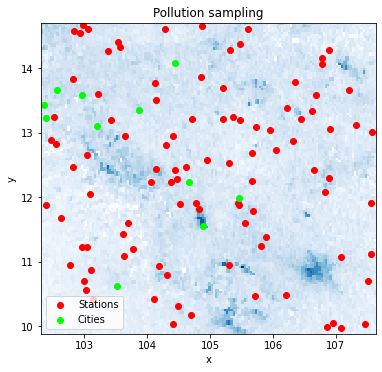

In [20]:
f, ax = plt.subplots(1, figsize=(6, 6))

pollution.where(
    pollution>0
).plot(
    add_colorbar=False, cmap="Blues", ax=ax
)

stations.plot(ax=ax, color="red", label="Stations")
cities.plot(ax=ax, color="lime", label="Cities")

ax.set_title("Pollution sampling")

plt.legend();

We will need the location and the pollution measurements for every station as separate arrays. Before we do that, since we will be calculating distances, we convert our coordinates to [a system](http://epsg.io/5726) expressed in metres.

In [21]:
stations_mt = stations.to_crs(epsg=5726)
station_xys = np.array(
    [stations_mt.geometry.x, stations_mt.geometry.y]
).T

We also need to extract the pollution measurements for each station location:

In [22]:
station_measurements = np.array(
    point_query(
        stations,
        pollution.values,
        affine=pollution.rio.transform(),
        nodata=pollution.rio.nodata
    )
)

And finally, we will also need the locations of each city expressed in the same coordinate system:

In [23]:
cities_mt = cities.to_crs(epsg=5726)
city_xys = np.array(
    [cities_mt.geometry.x, cities_mt.geometry.y]
).T

For this illustration, we will use a $k$-nearest neighbors regression that estimates the value for each target point (`cities` in our case) as the average weighted by distance of its $k$ nearest neigbors. In this illustration we will use $k=10$.

```{margin}
Note how `sklearn` relies only on array data structures, hence why we first had to express all the required information in that format
```

In [24]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(
    n_neighbors=10, weights="distance"
).fit(station_xys, station_measurements)

Once we have trained the model, we can use it to obtain predictions for each city location:

In [25]:
predictions = model.predict(city_xys)

These can be compared with the originally observed values:

In [26]:
p2p_comparison = pandas.DataFrame(
    {
        "Observed": city_pollution,
        "Predicted": predictions
    },
    index=cities["UC_NM_MN"]
)

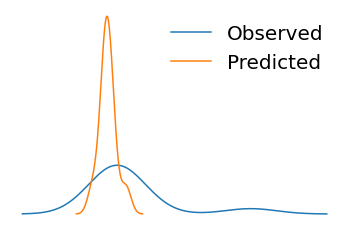

In [27]:
f, ax = plt.subplots(1)
p2p_comparison["Observed"].plot.kde(ax=ax)
p2p_comparison["Predicted"].plot.kde(ax=ax)
ax.set_axis_off()
plt.legend(frameon=False, fontsize=20);

In [28]:
p2p_comparison

,Observed,Predicted
UC_NM_MN,,
Sampov Lun,0.000039,0.000027
Khum Pech Chenda,0.000035,0.000025
Poipet,0.000038,0.000030
Sisophon,0.000041,0.000030
Battambang,0.000031,0.000027
Siem Reap,0.000051,0.000027
Sihanoukville,0.000023,0.000019
N/A,0.000041,0.000028
Kampong Chhnang,0.000024,0.000032


```{admonition} Challenge
Replicate the analysis above with $k=15$ and $k=5$. *Do results change? Why do you think that is?*
```

### Points to surface

Imagine we do not have a surface like `pollution` but we need it. In this context, if you have measurements from some locations, such as in `stations`, we can use the approach reviewed above to generate a surface. The trick to do this is to realise that we can generate a *uniform* grid of target locations that we can then express as a surface.

We will set as our target locations those of the pixels in the target surface we have seen {ref}`above <sfe_s2s>`:

In [29]:
canvas_mt = canvas.rio.reproject(5726)

In [30]:
xy_pairs = canvas_mt.to_series().index
xys = np.array(
    [
        xy_pairs.get_level_values("x"),
        xy_pairs.get_level_values("y")
    ]
).T

To obtain pollution estimates at each location, we can `predict` with `model`:

In [31]:
predictions_grid = model.predict(xys)

And with these at hand, we can convert them into a surface:

In [32]:
predictions_series = pandas.DataFrame(
    {"predictions_grid": predictions_grid}
).join(
    pandas.DataFrame(xys, columns=["x", "y"])
).set_index(["y", "x"])

predictions_surface = xarray.DataArray().from_series(
    predictions_series["predictions_grid"]
).rio.write_crs(canvas_mt.rio.crs)

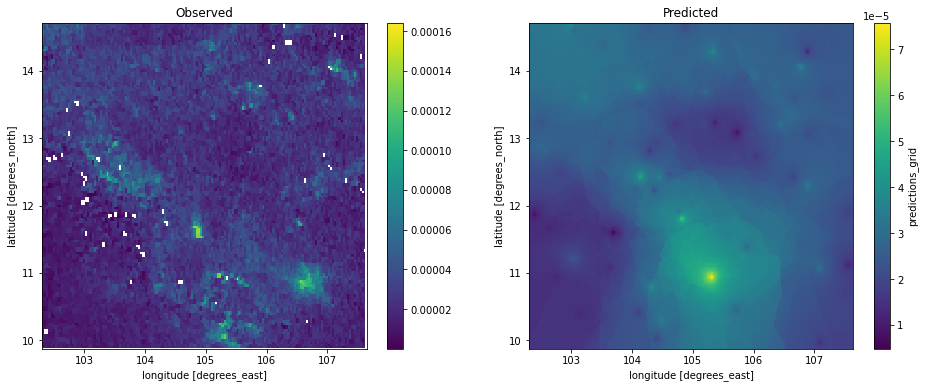

In [33]:
f, axs = plt.subplots(1, 2, figsize=(16, 6))

cvs_pollution.where(
    cvs_pollution>0
).plot(ax=axs[0])
axs[0].set_title("Observed")

predictions_surface.where(
    predictions_surface>0
).rio.reproject_match(
    cvs_pollution
).plot(ax=axs[1])
axs[1].set_title("Predicted")

plt.show()

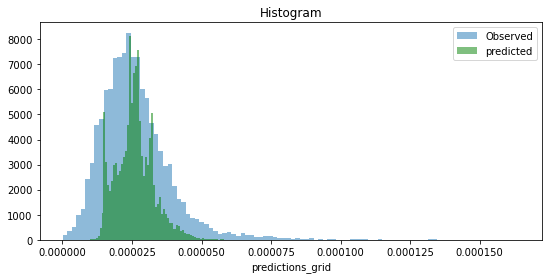

In [34]:
f, ax = plt.subplots(1, figsize=(9, 4))
cvs_pollution.where(
    cvs_pollution>0
).plot.hist(
    bins=100, alpha=0.5, ax=ax, label="Observed"
)
predictions_surface.rio.reproject_match(
    cvs_pollution
).plot.hist(
    bins=100, alpha=0.5, ax=ax, color="g", label="predicted"
)
plt.legend()
plt.show()

Room for improvement but, remember this was a rough first pass!

```{admonition} Challenge
Train a model with pollution measurements from each city location and generate a surface from it. *How does the output compare to the one above? Why do you think that is?*
```

(sfe_p2p)=

### Polygons to polygons

In this final example, we transfer data from a polygon geography to *another* polygon geography. Effectively, we re-apportion values from one set of areas to another based on the extent of shared area.

Our illustration will cover how to move pollution estimates from `regions` into a uniform hexagonal grid we will first create.

````{margin}
```{important}
This code requires `tobler` 0.7.0 or above
```
````

In [35]:
import tobler

hex_grid = tobler.util.h3fy(
    regions, resolution=5
)

/opt/conda/lib/python3.9/site-packages/tobler/util/util.py:151: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  source = source.explode()


Not that pollution is expressed as an *intesive* (rate) variable. We need to recognise this when specifying the interpolation model:

````{margin}
```{attention}
This feature requires `tobler` 6.0 or above
```
````

In [36]:
%%time
pollution_hex = tobler.area_weighted.area_interpolate(
    regions.assign(geometry=regions.buffer(0)).to_crs(epsg=5726),
    hex_grid.to_crs(epsg=5726), 
    intensive_variables=["no2_mean"]
)

CPU times: user 439 ms, sys: 12 ms, total: 451 ms
Wall time: 448 ms


And the results look like:

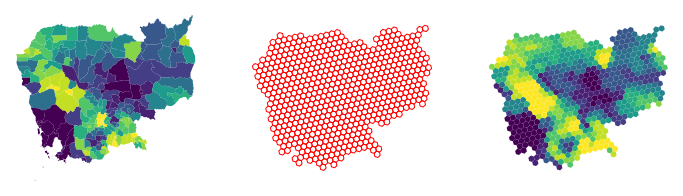

In [37]:
f, axs = plt.subplots(1, 3, figsize=(12, 4))

regions.plot(
    "no2_mean", scheme="quantiles", k=12, ax=axs[0]
)
axs[0].set_axis_off()

hex_grid.plot(
    facecolor="none", edgecolor="red", ax=axs[1]
)
axs[1].set_axis_off()

pollution_hex.to_crs(epsg=4326).plot(
    "no2_mean", scheme="quantiles", k=12, ax=axs[2]
)
axs[2].set_axis_off()

plt.show()

```{admonition} Challenge
Replicate the analytis using `resolution = 4`. *How is the result different? Why?*
```

## 🐾 Next steps

If you are interested in learning more about spatial feature engineering through map matching, the following pointers might be useful to delve deeper into specific types of "data transfer":

- The [`datashader`](https://datashader.org) library is a great option to transfer geo-tables into surfaces, providing tooling to perform these operations in a highly efficient and performant way.
- When aggregating surfaces into geo-tables, the library [`rasterstats`](https://pythonhosted.org/rasterstats/) contains most if not all of the machinery you will need.
- For transfers from polygon to polygon geographies, [`tobler`](https://pysal.org/tobler/) is your friend. Its official documentation contains examples for different use cases.